In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
tqdm.pandas()
from scipy import special
from scipy.stats import kstwobign, anderson
import scipy.stats.distributions as dist

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

plt.rcParams['font.size'] = 14

In [2]:
fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/'
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
res_folder = f'{fold}/results'
cos_dat_fold = 'E:/cosmos-data'

### Importing my Data

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [5]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best >= 9.25')

In [6]:
len(df_red)

3404

In [7]:
def get_redshift(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [44]:
df_redshifts = (
    df_red
    .assign(redshift = df_red.apply(lambda row: get_redshift(row.ez_z_phot,row.lp_zBEST), axis = 1))#
    .query('redshift <= 1.2')
)

In [45]:
df_IDS = (
    df_redshifts[['ID', 'ID_COSMOS2015']]
)

### Importing Dervish Data

In [46]:
environ_data = pd.read_csv(f'{cos_dat_fold}/darvish17-environ.csv')

In [47]:
len(environ_data)

45421

In [48]:
environ_data_red = environ_data.query('flag == 0').rename(columns = {'ID' : 'ID_COSMOS2015'})

In [49]:
len(environ_data_red)

38865

In [50]:
# df_noextra = (
#     df_red
#     .assign(extra_cont = df_red.ORyanID_23.apply(lambda x: 'y' if type(x) == str and 'extra' in x else 'n'))
#     .query('extra_cont == "n"')
#     .drop(columns = ['extra_cont'])
# )

In [51]:
# df_IDS = (
#     df_noextra[['ID', 'ID_COSMOS2015']]
# )

In [52]:
df_environ_match = (
    df_IDS.merge(environ_data_red, on = 'ID_COSMOS2015', how = 'left')
)

In [53]:
matched_red = df_environ_match[['ID', 'density', 'environment']].dropna()
matched_red

,ID,density,environment
1,860686,4.23,field
2,1304538,0.96,field
3,1310001,3.08,field
4,1308927,2.78,field
5,1311422,2.26,filament
...,...,...,...
3321,1407959,29.56,cluster
3322,1408623,6.72,filament
3323,1409169,1.12,field
3324,1410323,1.47,filament


In [32]:
matched_red.density.min()

0.22

In [33]:
matched_red.density.max()

89.07

In [34]:
log_matched_red = (
    matched_red
    .assign(log_density = matched_red.density.apply(lambda x: np.log10(x)))
)

In [20]:
log_matched_red.log_density.min()

-0.6575773191777937

In [21]:
log_matched_red.log_density.max()

1.949731452315707

### Diagnostics of Environment Measure

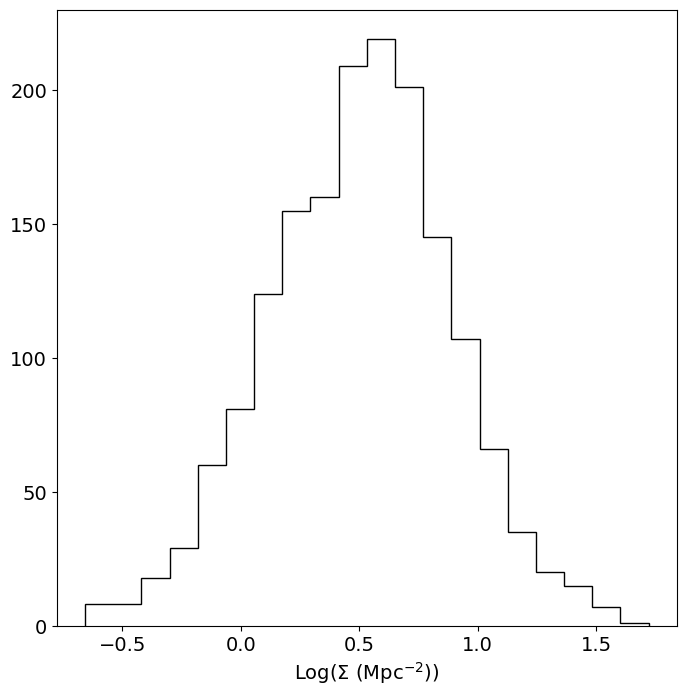

In [21]:
plt.figure(figsize = (8,8))
plt.hist(np.array(log_matched_red.log_density), bins = 20, histtype='step', color='black')
plt.xlabel('Log($\Sigma$ (Mpc$^{-2}$))')
plt.show()

In [22]:
df_cat = df_red[['ID', 'category', 'lp_mass_best', 'ez_sfr']]

In [23]:
df_environ_merg = log_matched_red.merge(df_cat, on = 'ID', how = 'left')
df_environ_merg

,ID,density,environment,log_density,category,lp_mass_best,ez_sfr
0,860686,4.23,field,0.626340,stage3,10.44862,1.609304
1,1304538,0.96,field,-0.017729,stage3,9.96798,1.101499
2,1310001,3.08,field,0.488551,stage3,10.41827,1.083541
3,1308927,2.78,field,0.444045,stage3,10.03523,1.198906
4,1311422,2.26,filament,0.354108,stage3,9.64588,0.392114
...,...,...,...,...,...,...,...
1663,302055,2.60,field,0.414973,stage2,10.04962,0.907969
1664,715824,3.46,filament,0.539076,stage1,10.58314,1.029518
1665,1157587,4.71,filament,0.673021,stage3,10.56569,0.131293
1666,1203157,4.01,field,0.603144,stage3,10.25633,0.975221


In [24]:
df_environ_merg.category.value_counts()

stage3    679
stage2    422
stage4    330
stage1    237
Name: category, dtype: int64

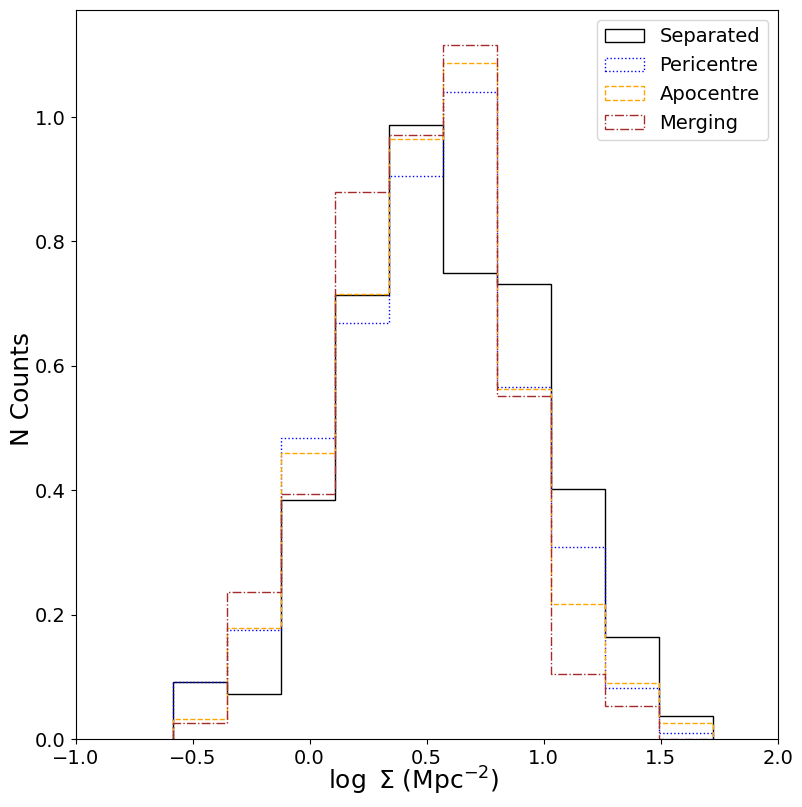

In [25]:
counter = 1
colours = ['black','blue','orange', 'brown']
linestyles = ['solid', 'dotted','dashed','dashdot']
fig, ax = plt.subplots(figsize = (8,8))
_, thebins = np.histogram(df_environ_merg.query('category == "stage1"').log_density, bins = 10)
for i in range(4):
    stage = f'stage{counter}'
    densities = np.array(df_environ_merg.query('category == @stage').log_density)

    ax.hist(densities, bins = thebins, histtype='step', color=colours[i], linestyle=linestyles[i], density = True)
    ax.set_xlim([-1.0, 2.0])

    counter += 1

ax.legend(['Separated','Pericentre','Apocentre','Merging'])
fig.tight_layout()
fig.text(0.5, 0.01, '$\log$ $\Sigma$ (Mpc$^{-2}$)', ha='center', va='center', fontsize = 18)
fig.text(0.01, 0.5, 'N Counts', ha='center', va='center', rotation='vertical', fontsize = 18)
# fig.savefig(f'{fig_folder}/density-stage.pdf', bbox_inches = 'tight')
plt.show()

0.1308016877637131
0.0995260663507109
0.11782032400589101
0.1


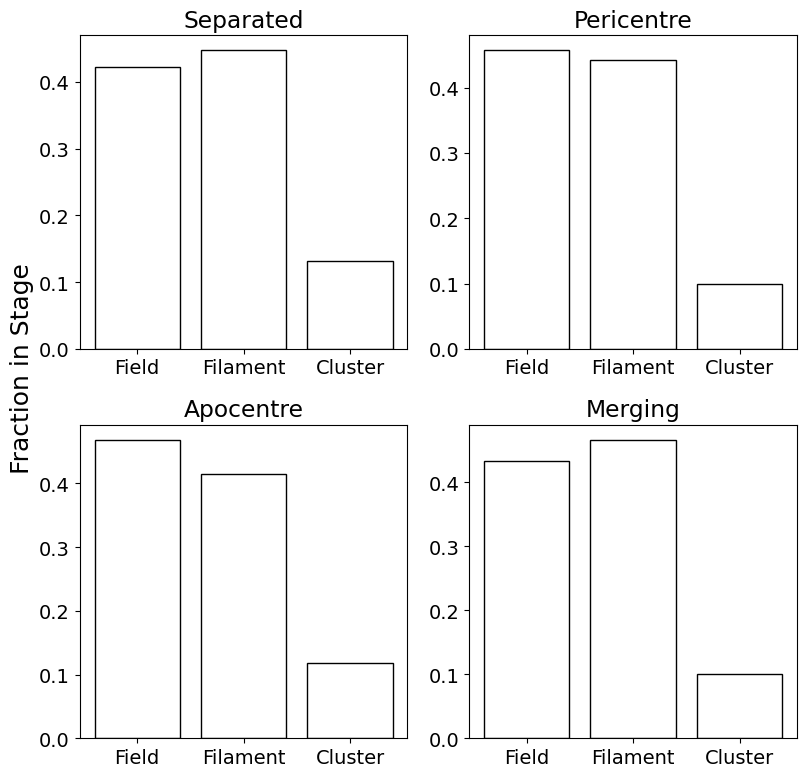

In [26]:
counter = 1
stages = ['Separated','Pericentre','Apocentre','Merging']
environments = ['Field', 'Filament', 'Cluster']
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_environ_merg.query('category == @stage')
        values = [df_stage.environment.value_counts().field / len(df_stage), df_stage.environment.value_counts().filament / len(df_stage), df_stage.environment.value_counts().cluster / len(df_stage)] 
        
        print(df_stage.environment.value_counts().cluster / len(df_stage))
        
        ax[i,j].bar(environments, values, fill=False)
        ax[i,j].set_title(stages[counter-1])
        
        counter += 1
        
fig.text(-0.01, 0.40, 'Fraction in Stage', rotation = 'vertical', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fig_folder}/environment-fractions.pdf', dpi = 500, bbox_inches = 'tight')
plt.show()

In [27]:
def weight_dist(arrs, bins=None, return_bins=True, renorm=False, compare = 3):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    if len(arrs) < 4:
        print('This has been set up to handle 4 distributions!')
        print('You have not provided four distributions.')
        sys.exit()
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    hists = []
    _, thebins = np.histogram(arrs[3], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    # hists.append(hist1)
    for i in arrs:
        hist_tmp, _ = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        # zero-"index"ing these because they're indices and not values
        # and if I get them mixed up below I want this to error that there's no b2 or whatever
        b0 = thebins[i_bin]
        b1 = thebins[i_bin+1]

        count1 = hists[0][i_bin]
        count2 = hists[1][i_bin]
        count3 = hists[2][i_bin]
        count4 = hists[3][i_bin]

        # don't miss any values and don't double-count
        if i_bin == 0:
            in_bin1 = (arrs[0] >= b0) & (arrs[0] <= b1)
            in_bin2 = (arrs[1] >= b0) & (arrs[1] <= b1)
            in_bin3 = (arrs[2] >= b0) & (arrs[2] <= b1)
            in_bin4 = (arrs[3] >= b0) & (arrs[3] <= b1)
        else: 
            in_bin1 = (arrs[0] >  b0) & (arrs[0] <= b1)
            in_bin2 = (arrs[1] >  b0) & (arrs[1] <= b1)
            in_bin3 = (arrs[2] >  b0) & (arrs[2] <= b1)
            in_bin4 = (arrs[3] >  b0) & (arrs[3] <= b1)
            
        # don't divide by 0 in the rest of the if/else
        if (count1 == 0) | (count2 == 0) | (count3 == 0) | (count4 == 0):
            ws_list[0][in_bin1] = 0.0
            ws_list[1][in_bin2] = 0.0
            ws_list[2][in_bin3] = 0.0
            ws_list[3][in_bin4] = 0.0

        elif count1 <= count2 and count1 <= count3 and count1 <= count4:
            # weight count2 values so the sum of wt2 in this bin equals count1
            # wt_fac will always be < 1
            ws_list[0][in_bin1] = 1.0
            ws_list[1][in_bin2] = float(count1)/float(count2)
            ws_list[2][in_bin3] = float(count1)/float(count3)
            ws_list[3][in_bin4] = float(count1)/float(count4)
            
        elif count2 <= count1 and count2 <= count3 and count2 <= count4:
            ws_list[0][in_bin1] = float(count2)/float(count1)
            ws_list[1][in_bin2] = 1.0
            ws_list[2][in_bin3] = float(count2)/float(count3)
            ws_list[3][in_bin4] = float(count2)/float(count4)
            
        elif count3 <= count1 and count3 <= count2 and count3 <= count4:
            ws_list[0][in_bin1] = float(count3)/float(count1)
            ws_list[1][in_bin2] = float(count3)/float(count2)
            ws_list[2][in_bin3] = 1.0
            ws_list[3][in_bin4] = float(count3)/float(count4)
            
        elif count4 <= count1 and count4 <= count2 and count4 <= count3:
            ws_list[0][in_bin1] = float(count4)/float(count1)
            ws_list[1][in_bin2] = float(count4)/float(count2)
            ws_list[2][in_bin3] = float(count4)/float(count3)
            ws_list[3][in_bin4] = 1.0
                        
        else:
            print('What the hell happened.')
            print(count1)
            print(count2)
            print(count3)
            print(count4)
            sys.exit()

        # else:
        #     # weight count1 values so the sum of wt1 in this bin equals count2
        #     # wt_fac will always be <= 1
        #     wt_fac = float(count2)/float(count1)
        #     ws_list[compare][in_bin1] = wt_fac
        #     ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws_list, thebins 
    else: 
        return ws_list

In [28]:
mass_s1 = np.array(df_environ_merg.query('category == "stage1"')['lp_mass_best'])
mass_s2 = np.array(df_environ_merg.query('category == "stage2"')['lp_mass_best'])
mass_s3 = np.array(df_environ_merg.query('category == "stage3"')['lp_mass_best'])
mass_s4 = np.array(df_environ_merg.query('category == "stage4"')['lp_mass_best'])

In [29]:
density_s1 = np.array(df_environ_merg.query('category == "stage1"')['log_density'])
density_s2 = np.array(df_environ_merg.query('category == "stage2"')['log_density'])
density_s3 = np.array(df_environ_merg.query('category == "stage3"')['log_density'])
density_s4 = np.array(df_environ_merg.query('category == "stage4"')['log_density'])

In [30]:
weights, thebins = weight_dist([mass_s1, mass_s2, mass_s3, mass_s4], bins = 10, renorm = False, return_bins = True)

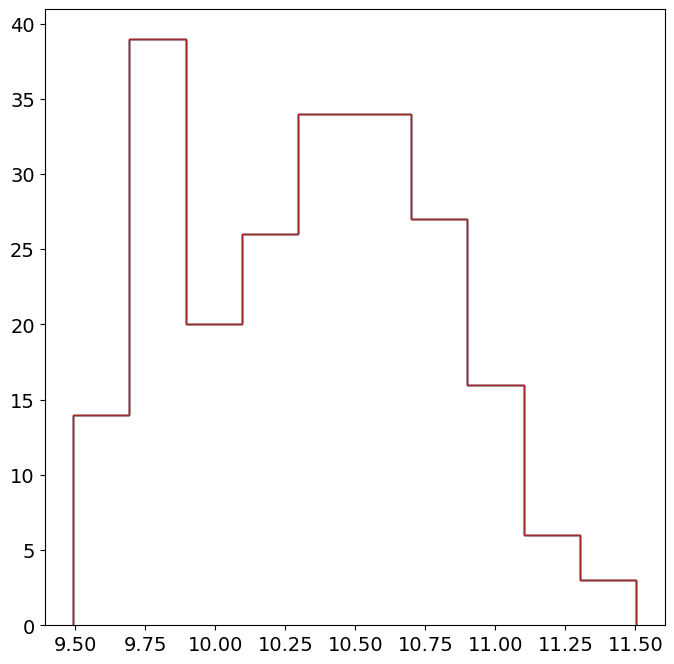

In [31]:
plt.figure(figsize = (8,8))
plt.hist(mass_s1, bins = thebins, weights=weights[0] , histtype = 'step', color = 'black')
plt.hist(mass_s2, bins = thebins, weights=weights[1] , histtype = 'step', color = 'blue')
plt.hist(mass_s3, bins = thebins, weights=weights[2] , histtype = 'step', color = 'orange')
plt.hist(mass_s4, bins = thebins, weights=weights[3] , histtype = 'step', color = 'brown')
plt.show()

In [32]:
_, bins_density = np.histogram(density_s1, bins = 10)

In [33]:
densities = [density_s1, density_s2,density_s3,density_s4]

In [34]:
p_dens = [[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    den_stage = densities[counter]    
    # Getting Confidence Interval
        
    _, bins = np.histogram(den_stage, bins=bins_density)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(den_stage > lower_bin) & (den_stage <= upper_bin)][0].astype(bool)
        
        den_bin = den_stage[mask]
        
        counts = len(den_bin)
        
        upper = counts + (1 * np.sqrt(counts + 1)) + ((1**2 + 2)/3)
        lower = counts - (1 * np.sqrt(counts)) + ((1*2 - 1) / 3)
                        
        if counts == 0:
            p_dens[counter].append([0,0])
        else:
            p_dens[counter].append([counts - lower,  upper - counts])

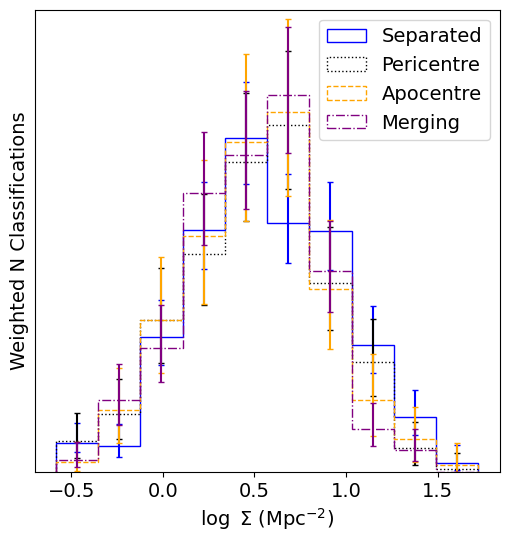

In [35]:
fig, ax = plt.subplots(figsize = (6,6))

colours = ['blue','black','orange','purple']
linestyles = ['solid', 'dotted','dashed','dashdot']
for i in range(4):
    bin_counts, bins = np.histogram(densities[i], bins = bins_density, weights=weights[i])
    bincenters = 0.5 * (bins[1:] + bins[:-1])
    
    error_array = np.asarray(p_dens[i]).T
    
    ax.hist(densities[i], bins = bins, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i])
    ax.errorbar(bincenters, bin_counts, yerr=error_array, linestyle = '', color=colours[i], barsabove=True, capsize=2.5)
    
    
plt.legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper right')
plt.ylim([0, 70])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$ $\Sigma$ (Mpc$^{-2}$)', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
plt.savefig(f'{fig_folder}/density-stage.pdf', bbox_inches = 'tight')
plt.show()

## Adding Control

In [36]:
control_manifest = pd.read_csv(f'{res_folder}/control_manifest.csv', index_col = 0)

In [37]:
control_manifest

,ID,control_ID
0,857121.0,302531.0
1,873195.0,1520080.0
2,861738.0,811824.0
3,1280765.0,1469804.0
4,1284864.0,1308059.0
...,...,...
6837,1294513.0,1233604.0
6838,1290594.0,552604.0
6839,1301552.0,1587284.0
6840,1315336.0,558317.0


In [38]:
with fits.open(f'{cos_dat_fold}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

In [39]:
df_env_controls = df_environ_merg[['ID']].merge(control_manifest, on = 'ID', how = 'left').dropna()

In [40]:
df_env_controls

,ID,control_ID
2,1310001,940821.0
3,1308927,1208843.0
4,1311422,550540.0
5,1264241,435889.0
6,280038,1283637.0
...,...,...
1662,275451,745400.0
1663,302055,1124661.0
1664,715824,1205347.0
1665,1157587,1306658.0


In [41]:
def get_cosmos2015_id(id_2020, data):
    row = data[(data['ID'] == id_2020)]
    id_2015 = row['ID_COSMOS2015']
    return id_2015[0]

In [42]:
df_control_id = (
    df_env_controls.assign(cosmos2015_id = df_env_controls.control_ID.progress_apply(lambda x: get_cosmos2015_id(x, data)))
)

100%|██████████| 1247/1247 [11:17<00:00,  1.84it/s]


In [43]:
df_valid_ids = df_control_id.query('cosmos2015_id != -99')

In [44]:
df_control_dens = (
    df_valid_ids
    .merge(environ_data, left_on = 'cosmos2015_id', right_on = 'ID', how = 'left')[['ID_x','control_ID','density','environment']]
    .dropna()
    .rename(columns = {'ID_x' : 'ID'})
)

In [45]:
def get_masses(id_control, data):
    row = data[(data['ID'] == id_control)]
    return row['lp_mass_best'][0]

In [46]:
df_cont_masses = (
    df_control_dens
    .assign(lp_mass_best = df_control_dens.control_ID.progress_apply(lambda x: get_masses(x, data)))
)

100%|██████████| 473/473 [04:01<00:00,  1.96it/s]


In [47]:
df_control_log_dens = (
    df_cont_masses
    .assign(log_density = df_cont_masses.density.apply(lambda x: np.log10(x)))
)

In [48]:
df_control_log_dens

,ID,control_ID,density,environment,lp_mass_best,log_density
0,1310001,940821.0,2.21,field,10.41705,0.344392
1,1308927,1208843.0,0.17,field,10.03533,-0.769551
2,1264241,435889.0,1.12,filament,10.54034,0.049218
3,280038,1283637.0,5.00,filament,10.77824,0.698970
4,261335,398543.0,1.36,field,10.12941,0.133539
...,...,...,...,...,...,...
728,847081,554792.0,2.06,filament,10.13835,0.313867
730,302055,1124661.0,3.78,filament,10.05576,0.577492
731,715824,1205347.0,7.41,filament,10.59129,0.869818
732,1157587,1306658.0,0.51,field,10.56034,-0.292430


In [49]:
df_control_log_dens.log_density.min()

-1.0969100130080565

In [50]:
df_control_log_dens.log_density.max()

1.866582677063549

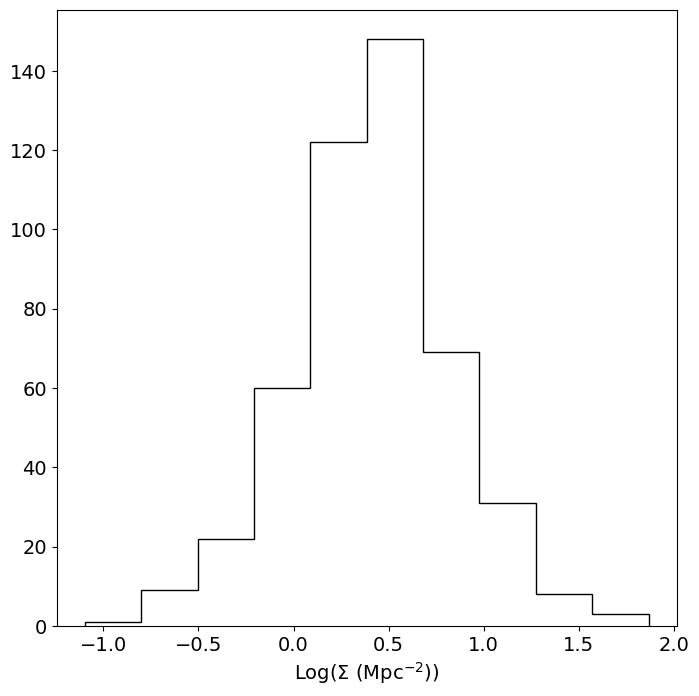

In [51]:
plt.figure(figsize = (8,8))
plt.hist(np.array(df_control_log_dens.log_density), bins = 10, histtype='step', color='black')
plt.xlabel('Log($\Sigma$ (Mpc$^{-2}$))')
plt.show()

In [66]:
def weight_dist_5(arrs, bins=None, return_bins=True, renorm=False, compare = 3):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    if len(arrs) != 5:
        print('This has been set up to handle 5 distributions!')
        print('You have not provided four distributions.')
        sys.exit()
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    hists = []
    _, thebins = np.histogram(arrs[0], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    # hists.append(hist1)
    for i in arrs:
        hist_tmp, _ = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        # zero-"index"ing these because they're indices and not values
        # and if I get them mixed up below I want this to error that there's no b2 or whatever
        b0 = thebins[i_bin]
        b1 = thebins[i_bin+1]

        count1 = hists[0][i_bin]
        count2 = hists[1][i_bin]
        count3 = hists[2][i_bin]
        count4 = hists[3][i_bin]
        count5 = hists[4][i_bin]

        # don't miss any values and don't double-count
        if i_bin == 0:
            in_bin1 = (arrs[0] >= b0) & (arrs[0] <= b1)
            in_bin2 = (arrs[1] >= b0) & (arrs[1] <= b1)
            in_bin3 = (arrs[2] >= b0) & (arrs[2] <= b1)
            in_bin4 = (arrs[3] >= b0) & (arrs[3] <= b1)
            in_bin5 = (arrs[4] >= b0) & (arrs[4] <= b1)
        else: 
            in_bin1 = (arrs[0] >  b0) & (arrs[0] <= b1)
            in_bin2 = (arrs[1] >  b0) & (arrs[1] <= b1)
            in_bin3 = (arrs[2] >  b0) & (arrs[2] <= b1)
            in_bin4 = (arrs[3] >  b0) & (arrs[3] <= b1)
            in_bin5 = (arrs[4] >  b0) & (arrs[4] <= b1)
            
        # don't divide by 0 in the rest of the if/else
        if (count1 == 0) | (count2 == 0) | (count3 == 0) | (count4 == 0):
            ws_list[0][in_bin1] = 0.0
            ws_list[1][in_bin2] = 0.0
            ws_list[2][in_bin3] = 0.0
            ws_list[3][in_bin4] = 0.0
            ws_list[4][in_bin5] = 0.0

        elif count1 <= count2 and count1 <= count3 and count1 <= count4 and count1 <= count5:
            # weight count2 values so the sum of wt2 in this bin equals count1
            # wt_fac will always be < 1
            ws_list[0][in_bin1] = 1.0
            ws_list[1][in_bin2] = float(count1)/float(count2)
            ws_list[2][in_bin3] = float(count1)/float(count3)
            ws_list[3][in_bin4] = float(count1)/float(count4)
            ws_list[4][in_bin5] = float(count1)/float(count5)
            
        elif count2 <= count1 and count2 <= count3 and count2 <= count4 and count2 <= count5:
            ws_list[0][in_bin1] = float(count2)/float(count1)
            ws_list[1][in_bin2] = 1.0
            ws_list[2][in_bin3] = float(count2)/float(count3)
            ws_list[3][in_bin4] = float(count2)/float(count4)
            ws_list[4][in_bin5] = float(count2)/float(count5)
            
        elif count3 <= count1 and count3 <= count2 and count3 <= count4 and count3 <= count5:
            ws_list[0][in_bin1] = float(count3)/float(count1)
            ws_list[1][in_bin2] = float(count3)/float(count2)
            ws_list[2][in_bin3] = 1.0
            ws_list[3][in_bin4] = float(count3)/float(count4)
            ws_list[4][in_bin5] = float(count3)/float(count5)
            
        elif count4 <= count1 and count4 <= count2 and count4 <= count3 and count4 <= count5:
            ws_list[0][in_bin1] = float(count4)/float(count1)
            ws_list[1][in_bin2] = float(count4)/float(count2)
            ws_list[2][in_bin3] = float(count4)/float(count3)
            ws_list[3][in_bin4] = 1.0
            ws_list[4][in_bin5] = float(count4)/float(count5)
            
        elif count5 <= count1 and count5 <= count2 and count5 <= count3 and count5 <= count4:
            ws_list[0][in_bin1] = float(count5)/float(count1)
            ws_list[1][in_bin2] = float(count5)/float(count2)
            ws_list[2][in_bin3] = float(count5)/float(count3)
            ws_list[3][in_bin4] = float(count5)/float(count4)
            ws_list[4][in_bin5] = 1.0
                        
        else:
            print('What the hell happened.')
            print(count1)
            print(count2)
            print(count3)
            print(count4)
            sys.exit()

        # else:
        #     # weight count1 values so the sum of wt1 in this bin equals count2
        #     # wt_fac will always be <= 1
        #     wt_fac = float(count2)/float(count1)
        #     ws_list[compare][in_bin1] = wt_fac
        #     ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws_list, thebins 
    else: 
        return ws_list

In [67]:
masses_dens = list(df_control_log_dens.lp_mass_best)

In [68]:
weights, thebins = weight_dist_5([mass_s1, mass_s2, mass_s3, mass_s4, masses_dens], bins = 10, renorm = False, return_bins = True)

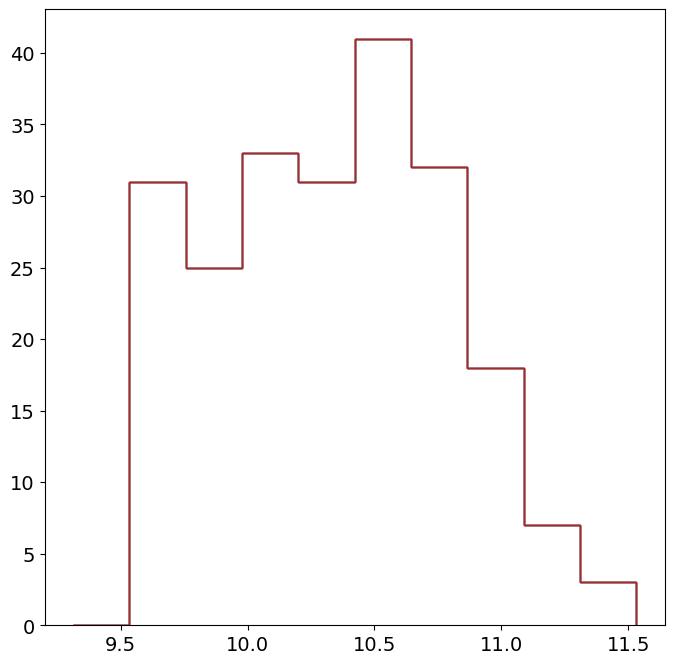

In [69]:
plt.figure(figsize = (8,8))
plt.hist(mass_s1, bins = thebins, weights=weights[0] , histtype = 'step', color = 'black')
plt.hist(mass_s2, bins = thebins, weights=weights[1] , histtype = 'step', color = 'blue')
plt.hist(mass_s3, bins = thebins, weights=weights[2] , histtype = 'step', color = 'orange')
plt.hist(mass_s4, bins = thebins, weights=weights[3] , histtype = 'step', color = 'brown')
plt.hist(masses_dens, bins = thebins, weights=weights[4] , histtype = 'step', color = 'brown')
plt.show()

In [78]:
control_dens = np.asarray(df_control_log_dens.log_density)

In [80]:
densities = [density_s1, density_s2, density_s3, density_s4, control_dens]

In [106]:
p_dens = [[],[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    den_stage = densities[counter]  
    weights_stage = weights[counter]
    # Getting Confidence Interval
        
    _, bins = np.histogram(den_stage, bins=bins_density)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(den_stage > lower_bin) & (den_stage <= upper_bin)][0].astype(bool)
        
        den_bin = den_stage[mask]
        weights_bin = weights_stage[mask]
                
        counts = np.sum(weights_bin * np.ones(len(den_bin)))
                        
        upper = counts + (1 * np.sqrt(counts + 1)) + ((1**2 + 2)/3)
        lower = counts - (1 * np.sqrt(counts)) + ((1*2 - 1) / 3)
                        
        if counts == 0:
            p_dens[counter].append([0,0])
        else:
            p_dens[counter].append([(counts - lower),  (upper - counts)])

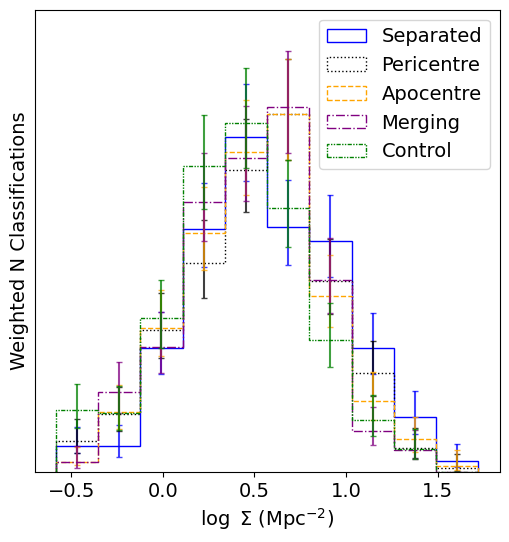

In [108]:
fig, ax = plt.subplots(figsize = (6,6))

colours = ['blue','black','orange','purple', 'green']
linestyles = ['solid', 'dotted','dashed','dashdot', (0, (3, 1, 1, 1, 1, 1))]
for i in range(5):
    bin_counts, bins = np.histogram(densities[i], bins = bins_density, weights=weights[i])
    bincenters = 0.5 * (bins[1:] + bins[:-1])
    
    error_array = np.asarray(p_dens[i]).T
    
    ax.hist(densities[i], bins = bins, histtype='step', color=colours[i], weights=weights[i], linestyle=linestyles[i])
    ax.errorbar(bincenters, bin_counts, yerr=error_array, linestyle = '', color=colours[i], barsabove=True, capsize=2.5, alpha = 0.75)
    
    
plt.legend(['Separated','Pericentre','Apocentre','Merging', 'Control'], loc='upper right')
plt.ylim([0, 72])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$ $\Sigma$ (Mpc$^{-2}$)', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
plt.savefig(f'{fig_folder}/density-stage.pdf', bbox_inches = 'tight')
plt.show()

## Checking Weights

In [92]:
def ks_weighted(arr1_all, arr2_all, w1_all, w2_all, return_dist=False):

    '''
    Given 2 arrays and their weights, returns Kolmogorov-Smirnov statistic and significance.

    This differs from the usual K-S test in that it computes a weighted K-S statistic and
    assumes the size of each sample is equal to the sum of the weights, not the length of
    the array. It's not exactly standard statistical practice to do this, so use with 
    caution, but it doesn't seem like a completely ridiculous idea, either.

        Parameters:
            arr1_all   (array): a data sample with values to be weighted by w1_all
            arr2_all   (array): a data sample with values to be weighted by w2_all
            w1_all     (array): weights for arr1_all
            w2_all     (array): weights for arr2_all
            return_dist (bool): True if the array of all K-S distances should be returned,
                                default is False (mostly only useful for debugging)

            Note: the arrays should be np.array() but other data types based on that should
                  work too, e.g. pd.Series, Astropy Table columns, etc. -- but if you get
                  an error on those, wrap your inputs with np.array().

        Returns:
            ks:     the weighted, 2-sided K-S statistic
            p_ks:   the p-value based on the weighted K-S statistic
            sig_ks: the significance level (in sigma) assuming p-values are distributed Normally

            if return_dist == True, also:
                dist_arr: array of KS-distances in raw format (sorted by increasing data sample value)
                          seriously this is not useful statistically, it's just for debugging

    '''

    # drop dead weight
    arr1 = np.array(arr1_all[w1_all > 0.0])
    arr2 = np.array(arr2_all[w2_all > 0.0])
    w1   = np.array(  w1_all[w1_all > 0.0])
    w2   = np.array(  w2_all[w2_all > 0.0])

    # get effective lengths of the weighted arrays
    n1 = np.sum(w1)
    n2 = np.sum(w2)
 
    # this is used below in the k-s calculation
    # (weighted sample sizes)
    ct = np.sqrt((n1+n2)/(n1*n2))

    # we want to sort the arrays, and the weights
    i1 = arr1.argsort()
    i2 = arr2.argsort()

    # sort arrays and weights in increasing order
    arr1_s = np.array(arr1[i1])
    w1_s   = np.array(  w1[i1])
    arr2_s = np.array(arr2[i2])
    w2_s   = np.array(  w2[i2])

    # make combined arrays but track which element comes from what, then sort them again
    both   = np.concatenate([arr1_s, arr2_s])
    both_w = np.concatenate([  w1_s,   w2_s])
    track  = np.concatenate([np.zeros(len(arr1_s), dtype=int), np.ones(len(arr2_s), dtype=int)])

    i_both   = both.argsort()
    both_s   = np.array(  both[i_both])
    both_w_s = np.array(both_w[i_both])
    track_s  = np.array( track[i_both])

    # go through array, once, computing the distance as we go, and track the max distance between cumulative curves
    # (which are both stored in the same array)
    # both cumulative curves start at 0 so the distance starts at 0
    # also cumulative curves always increase
    the_dist = 0.0
    dist_arr = np.zeros_like(both_s)
    max_dist = 0.0
    for j, this_which in enumerate(track_s):
        # the key here is the distance between curves goes up if array A has a new value,
        # and then if B has a new value that curve increases too so the curves get closer together
        # (the distance goes down).
        # it doesn't matter which is curve A and which is curve B, just that one increments 
        # and the other decrements.
        # if we were doing a regular K-S without weights, each new value for a given array changes
        # the distance between curves by 1 count. 
        # (with weighted, it only changes the distance by that object's weight.)
        # And also, these are cumulative curves, so each curve is divided by the total counts in that array
        # (which in the weighted case means the sum of the weights)
        # as a check, the distances should start at 0 and end at 0 (because the cumulative fractional
        # histograms both start at 0.0 and end at 1.0)
        if this_which == 0:
            the_dist += both_w_s[j]/n1
        else:
            the_dist -= both_w_s[j]/n2

        dist_arr[j] = the_dist
        if np.abs(the_dist) > max_dist:
            max_dist = np.abs(the_dist) 

    # the max dist over the whole cumulative curves is the K-S distance
    ks = max_dist
    # p-value (which also cares about the sample sizes)
    p_ks   = special.kolmogorov(float(ks)/float(ct))
    # scipy.stats.ks_2samp uses this instead?
    p_ksalt   = kstwobign.sf(((1./ct) + 0.12 + (0.11 * ct)) * ks)
    #print(p_ksalt)

    # what's the significance assuming a normal distribution? (1 = 1 sigma, 2. = 2 sigma, 3. = 3 sigma result etc.)
    sig_ks = special.erfcinv(p_ks)*np.sqrt(2.)



    if return_dist:
        return ks, p_ks, sig_ks, dist_arr
    else: 
        return ks, p_ks, sig_ks

In [95]:
ks_m_12, p_ks_m_12, sig_ks_12 = ks_weighted(densities[0], densities[1], weights[0], weights[1], return_dist=False)
ks_m_13, p_ks_m_13, sig_ks_13 = ks_weighted(densities[0], densities[2], weights[0], weights[2], return_dist=False)
ks_m_14, p_ks_m_14, sig_ks_14 = ks_weighted(densities[0], densities[3], weights[0], weights[3], return_dist=False)
ks_m_15, p_ks_m_15, sig_ks_15 = ks_weighted(densities[0], densities[4], weights[0], weights[4], return_dist=False)

In [96]:
print(f'KS Score Mass between stages 1 and 2 = {ks_m_12}')
print(f'KS Score Mass between stages 1 and 3 = {ks_m_13}')
print(f'KS Score Mass between stages 1 and 4 = {ks_m_14}')
print(f'KS Score Mass between stages 1 and control = {ks_m_15}')
print(' ')
print(f'KS-test p-value Mass between stages 1 and 2 = {p_ks_m_12}')
print(f'KS-test p-value Mass between stages 1 and 3 = {p_ks_m_13}')
print(f'KS-test p-value Mass between stages 1 and 4 = {p_ks_m_14}')
print(f'KS-test p-value Mass between stages 1 and control = {p_ks_m_15}')
print(' ')
print(f'KS-test significance Mass between stages 1 and 2 = {sig_ks_12}')
print(f'KS-test significance Mass between stages 1 and 3 = {sig_ks_13}')
print(f'KS-test significance Mass between stages 1 and 4 = {sig_ks_14}')
print(f'KS-test significance Mass between stages 1 and control = {sig_ks_15}')

KS Score Mass between stages 1 and 2 = 0.08035903637602312
KS Score Mass between stages 1 and 3 = 0.10520867088480718
KS Score Mass between stages 1 and 4 = 0.12194905697984028
KS Score Mass between stages 1 and control = 0.1653429978769343
 
KS-test p-value Mass between stages 1 and 2 = 0.47336628994479896
KS-test p-value Mass between stages 1 and 3 = 0.17312836088905292
KS-test p-value Mass between stages 1 and 4 = 0.07475624141786796
KS-test p-value Mass between stages 1 and control = 0.00475471430363007
 
KS-test significance Mass between stages 1 and 2 = 0.7170126521176138
KS-test significance Mass between stages 1 and 3 = 1.3622203327040785
KS-test significance Mass between stages 1 and 4 = 1.781957016870566
KS-test significance Mass between stages 1 and control = 2.823198366603319
